In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from templates import *
from templates_cls import *
import monai.transforms as T
from monai.utils.misc import first

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [2]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(60, 10))
    for i, img in enumerate(imgs):
        ndarr = img.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
        img = Image.fromarray(ndarr)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
device = 'cuda:0'
conf = brats64_autoenc()
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 86.63 M


In [4]:
batch_size = 1
channel = 0  # 0 = Flair
train_transforms = T.Compose(
[
        T.LoadImaged(keys=["image", "label"]),
        T.EnsureChannelFirstd(keys=["image", "label"]),
        T.Lambdad(keys=["image"], func=lambda x: x[channel, None, :, :, :]),
        T.EnsureTyped(keys=["image", "label"]),
        T.Orientationd(keys=["image", "label"], axcodes="RAS"),
        T.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        T.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64)),
        T.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        T.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        T.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
        #T.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        ##T.Lambdad(keys=["slice_label"], func=lambda x: 1.0 if (x == 2 or x == 1).any() else 0.0),
]
)

dataset_train =  DecathlonDataset(
root_dir="/DATA/NAS/datasets_source/brain",
task="Task01_BrainTumour",
section="training",
cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
num_workers=4,
download=True,  # Set download to True if the dataset hasnt been downloaded yet
seed=0,
transform=train_transforms,
)

train_loader = DataLoader(dataset_train, batch_size, shuffle=False, num_workers=8, pin_memory=True)

2024-03-27 17:09:26,341 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-03-27 17:09:26,343 - INFO - File exists: /DATA/NAS/datasets_source/brain/Task01_BrainTumour.tar, skipped downloading.
2024-03-27 17:09:26,344 - INFO - Non-empty folder exists in /DATA/NAS/datasets_source/brain/Task01_BrainTumour, skipped extracting.


Loading dataset:  10%|▉         | 37/388 [00:15<02:00,  2.92it/s]

In [ ]:
val_transforms = T.Compose(
[
        T.LoadImaged(keys=["image", "label"]),
        T.EnsureChannelFirstd(keys=["image", "label"]),
        T.Lambdad(keys=["image"], func=lambda x: x[channel, None, :, :, :]),
        T.EnsureTyped(keys=["image", "label"]),
        T.Orientationd(keys=["image", "label"], axcodes="RAS"),
        T.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        T.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64)),
        T.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        T.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1)),
        T.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
        #T.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        #T.Lambdad(keys=["slice_label"], func=lambda x: 1.0 if (x == 2 or x == 1).any() else 0.0),
]
)

dataset_val =  DecathlonDataset(
root_dir="/DATA/NAS/datasets_source/brain",
task="Task01_BrainTumour",
section="validation",
cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
num_workers=4,
download=True,  # Set download to True if the dataset hasnt been downloaded yet
seed=0,
transform=val_transforms,
)

val_loader = DataLoader(dataset_val, batch_size, shuffle=False, num_workers=8, pin_memory=True)

2024-03-26 10:26:17,264 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-03-26 10:26:17,268 - INFO - File exists: /DATA/NAS/datasets_source/brain/Task01_BrainTumour.tar, skipped downloading.
2024-03-26 10:26:17,269 - INFO - Non-empty folder exists in /DATA/NAS/datasets_source/brain/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 96/96 [00:43<00:00,  2.23it/s]


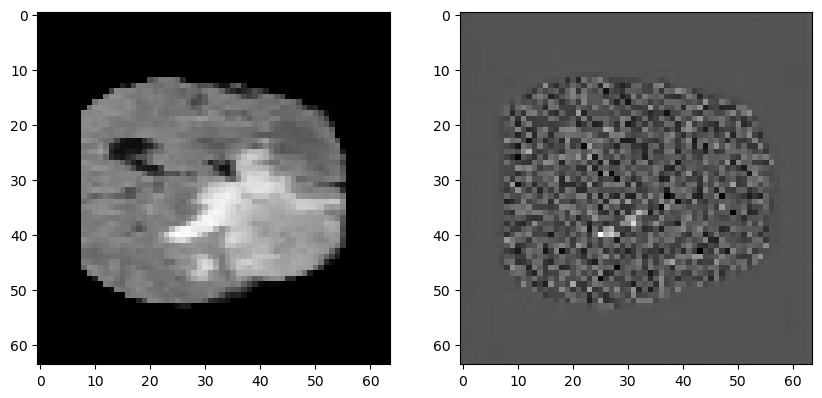

In [7]:
orig = first(val_loader)['image'].to(device)
x_s = model.encode(orig, ema=True)
xT = model.encode_stochastic(orig, x_s, T=250, ema=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(orig[0].permute(1, 2, 0).cpu(), cmap="gray")
ax[1].imshow(xT[0].permute(1, 2, 0).cpu(), cmap="gray")

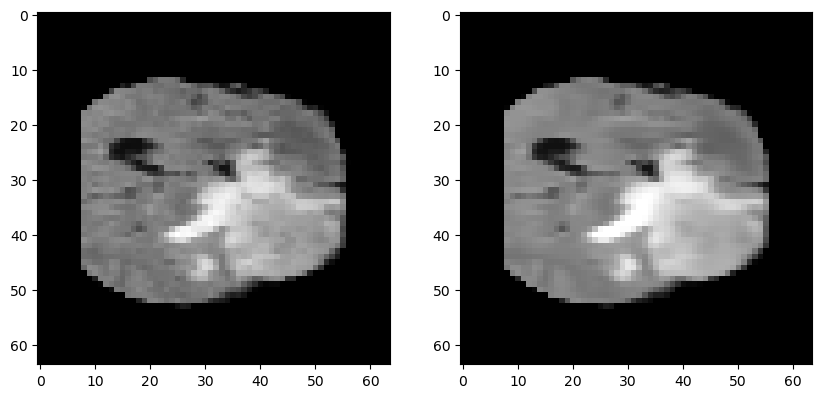

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
recon = model.render(xT, x_s, T=100, ema=True)

ax[0].imshow(orig[0].permute(1, 2, 0).cpu(), cmap="gray")
ax[1].imshow(recon[0].permute(1, 2, 0).cpu(), cmap="gray")

In [ ]:
len(dataset_train) + len(dataset_val)

In [29]:
with torch.no_grad():
    train_latents = list()
    train_labels = list()
    for batch in tqdm(train_loader):
        img = batch["image"]
        cond = model.encode(img.to(device), ema=True)
        cond = cond.cpu()
        label = int((batch["label"].numpy() == 2).any())

        train_latents.append(cond)
        train_labels.append(label)

    train_latents_np = torch.cat(train_latents, dim=0).cpu().detach().numpy()
    train_labels_np = np.array(train_labels).ravel()


    val_latents = list()
    val_labels = list()
    for batch in tqdm(val_loader):
        img = batch["image"]
        cond = model.encode(img.to(device), ema=True)
        cond = cond.cpu()
        label = int((batch["label"].numpy() == 2).any())

        val_latents.append(cond)
        val_labels.append(label)

    val_latents_np = torch.cat(val_latents, dim=0).cpu().detach().numpy()
    val_labels_np = np.array(val_labels).ravel()


  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

In [30]:
np.unique(train_labels, return_counts=True)

(array([0, 1]), array([263, 125]))

In [11]:
latents = {
    "train": {"latents": train_latents_np, "labels": train_labels_np},
    "val": {"latents": val_latents_np, "labels": val_labels_np}
} 

torch.save(latents, "retina_brats.pt")

In [7]:
latents = torch.load("latents/retina_brats.pt")
train_latents_np = latents["train"]["latents"]
train_labels_np = latents["train"]["labels"]
val_latents_np = latents["val"]["latents"]
val_labels_np = latents["val"]["labels"]

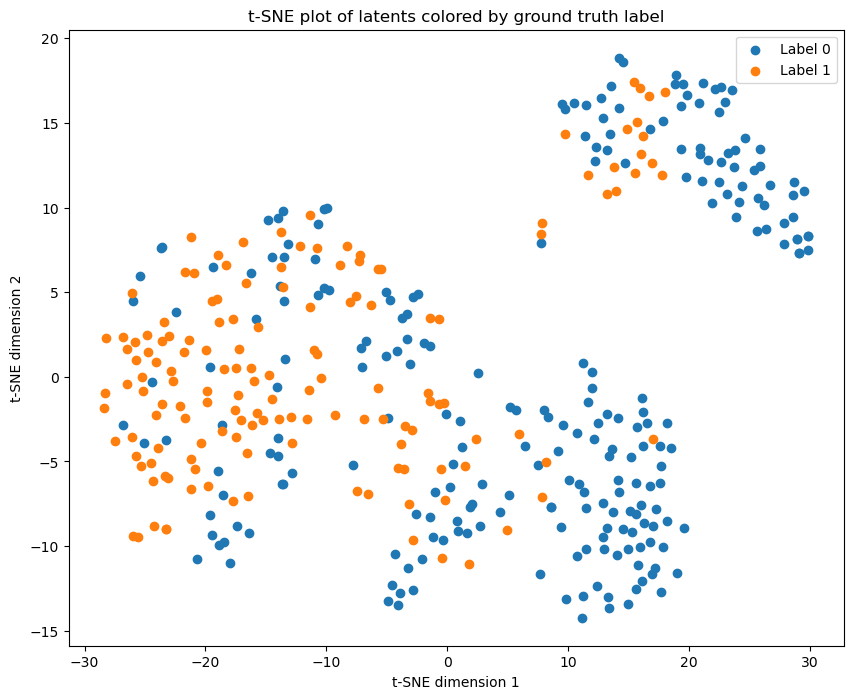

In [18]:
from sklearn.manifold import TSNE

# Run t-SNE on the dataset
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(train_latents_np)

# Plotting the result, coloring by label
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels_np):
    plt.scatter(latents_2d[train_labels_np == label, 0], latents_2d[train_labels_np == label, 1], label=f'Label {label}')

plt.legend()
plt.title('t-SNE plot of latents colored by ground truth label')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

In [31]:
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# Convert labels to binary: 0 stays 0, anything above 0 becomes 1
y_train = (train_labels_np > 0).astype(int)
y_test = (val_labels_np > 0).astype(int)


# Train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear', random_state=42)  # Using a linear kernel
svm_model.fit(train_latents_np, y_train)

# Predict on the test set
svm_predictions = svm_model.predict(val_latents_np)
# Evaluate the models
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

f1 = f1_score(y_test, svm_predictions)
print("SVM F1:", f1)

auc = roc_auc_score(y_test, svm_predictions)
print("SVM AUC:", auc)

SVM Accuracy: 0.78125
SVM F1: 0.8489208633093526
SVM AUC: 0.7354929577464788


In [39]:
latnets_mean = np.mean(train_latents_np, axis=0)
latnets_std = np.std(train_latents_np, axis=0)

def move_across_boundary(sample, svm_model, gt_grade):
    dists = list()

    w = svm_model.coef_ 
    w = w / (np.linalg.norm(w) * np.sqrt(512))
    b = svm_model.intercept_

    # Decision function value for the original sample
    decision_value = np.dot(w, sample.T) + b
    dists.append(decision_value[0][0])
    print("Before Dist: ", decision_value[0][0])

    # normalize sample before editing
    sample = (sample - latnets_mean) / latnets_std
    
    # Determine the direction to move the sample based on its initial classification
    #direction = -np.sign(decision_value)
    direction = 1 if gt_grade == 0 else -1
    
    # Modify the sample
    edited = list()
    for step_size in np.arange(200, 1001, 200):
        modified_sample = sample + direction * step_size * w
        modified_sample = modified_sample * latnets_std + latnets_mean

        decision_value =  np.dot(w, modified_sample.T) + b
        dists.append(decision_value[0][0])
        modified_sample = torch.tensor(modified_sample, requires_grad=False, device=device).float()

        edited.append(modified_sample)

    print(dists)
    return edited

GT Label:  1 0
Before Dist:  1.4455656492650388
[1.4455656492650388, 1.3030657613197725, 1.1605658734639235, 1.0180659856080747, 0.8755660977522257, 0.7330662098963769]


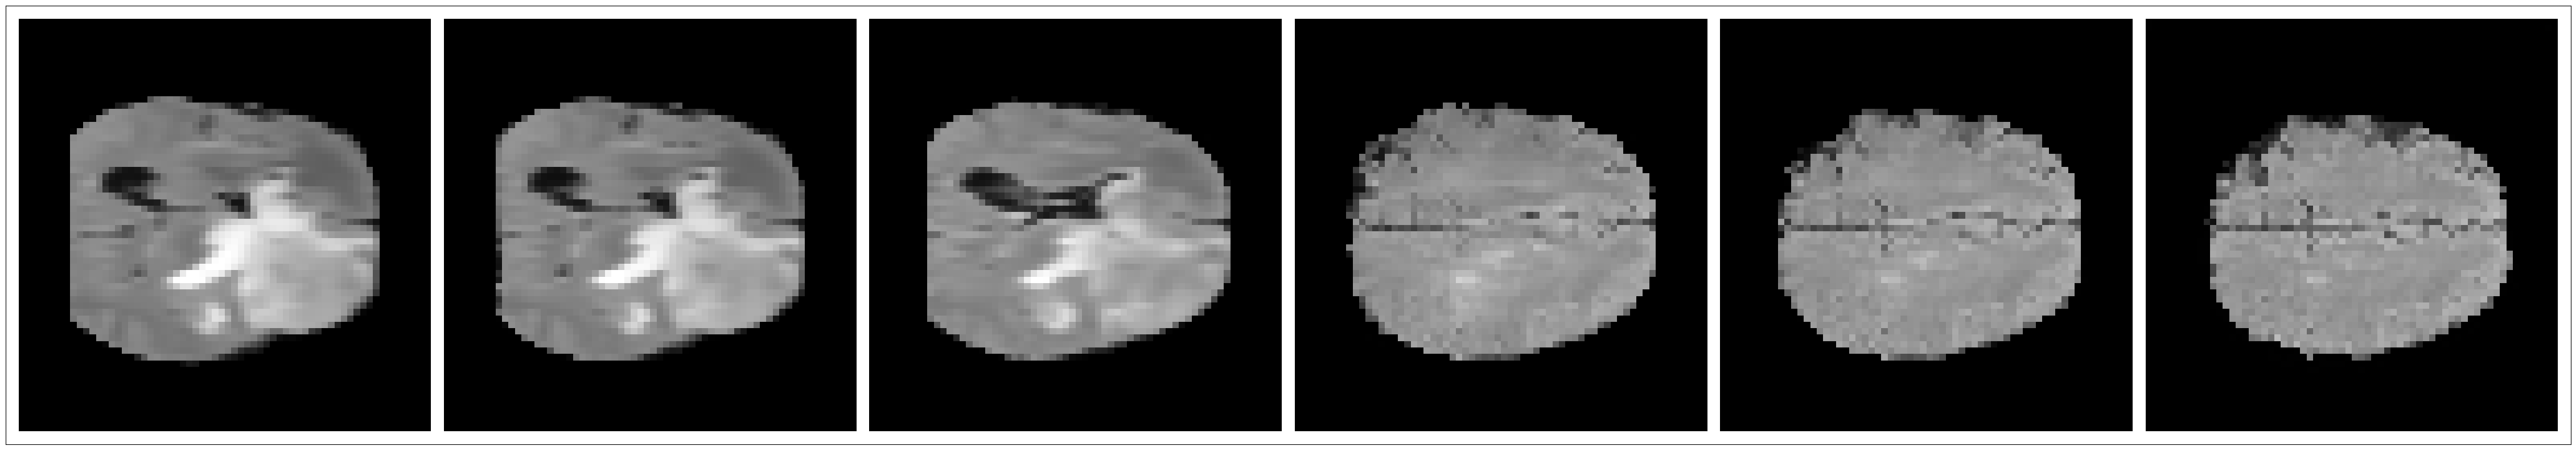

GT Label:  1 1
Before Dist:  1.4431742601802948
[1.4431742601802948, 1.3006743734442314, 1.1581744855883827, 1.0156745977325337, 0.8731747098766848, 0.7306748220208359]


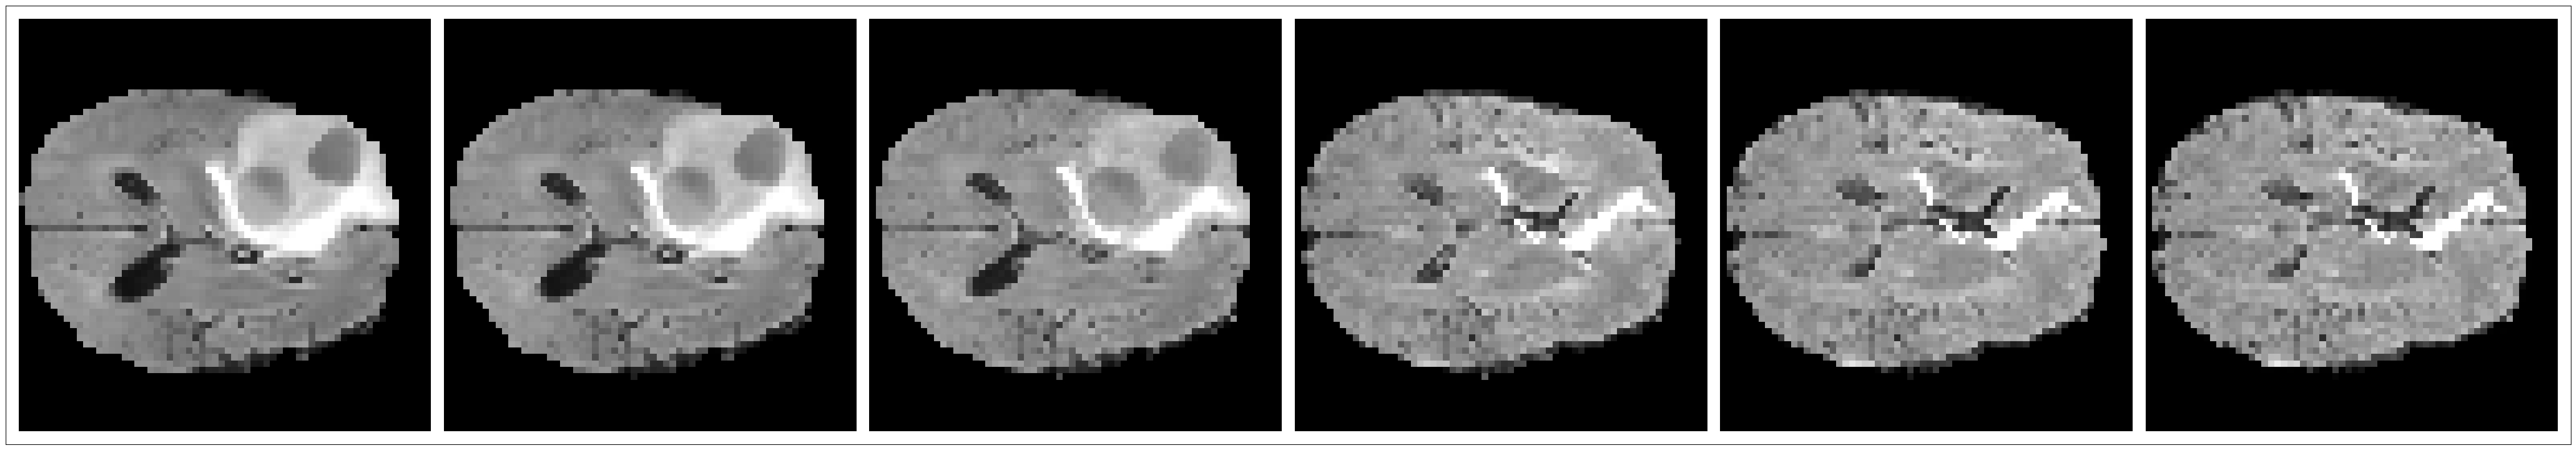

GT Label:  1 3
Before Dist:  1.3976162227444273
[1.3976162227444273, 1.2551163364654045, 1.1126164486095556, 0.9701165607537067, 0.8276166728978578, 0.685116785042009]


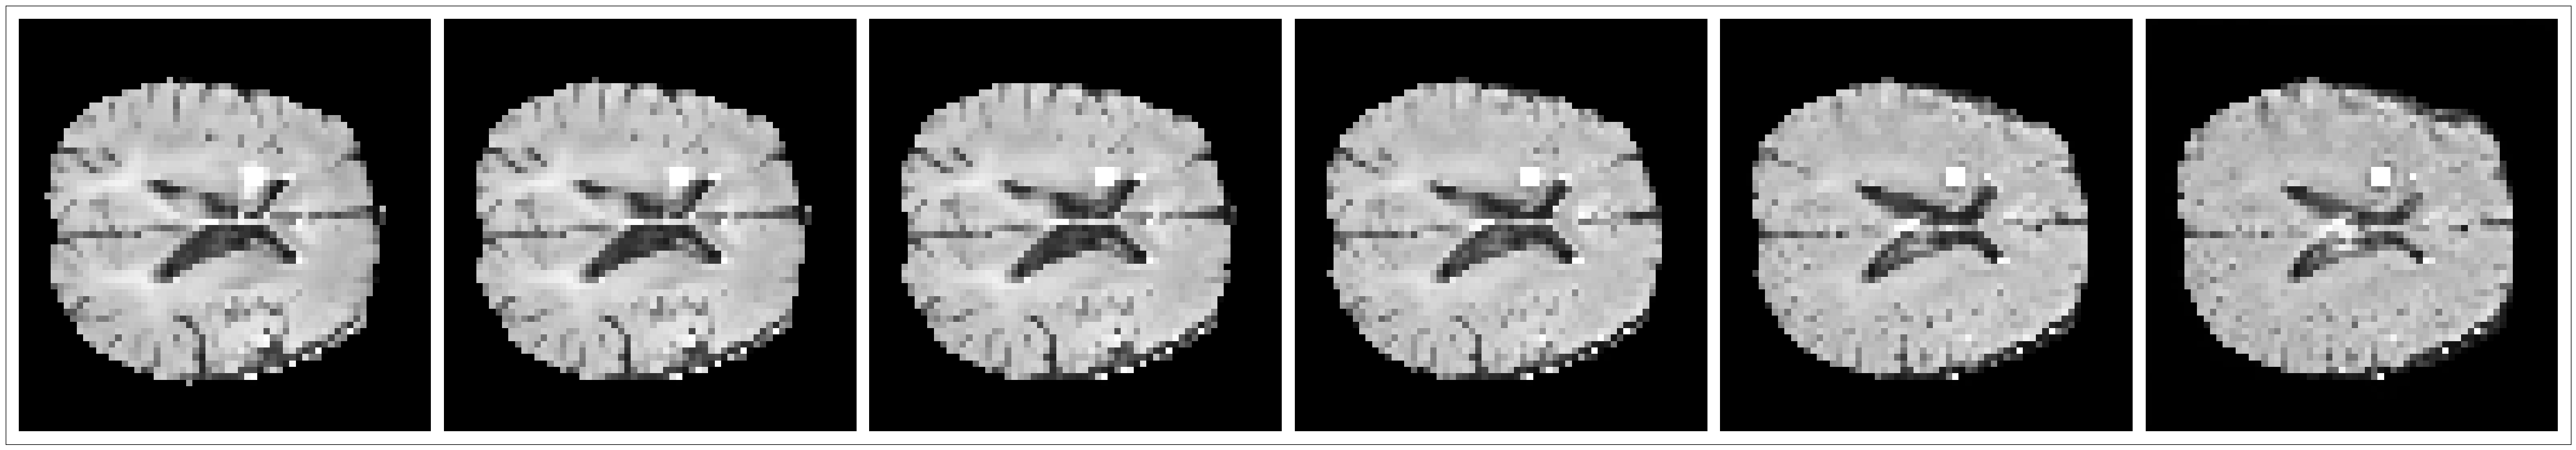

GT Label:  1 4
Before Dist:  1.445846116044523
[1.445846116044523, 1.3033462294607672, 1.1608463416049184, 1.0183464537490694, 0.8758465658932206, 0.7333466780373717]


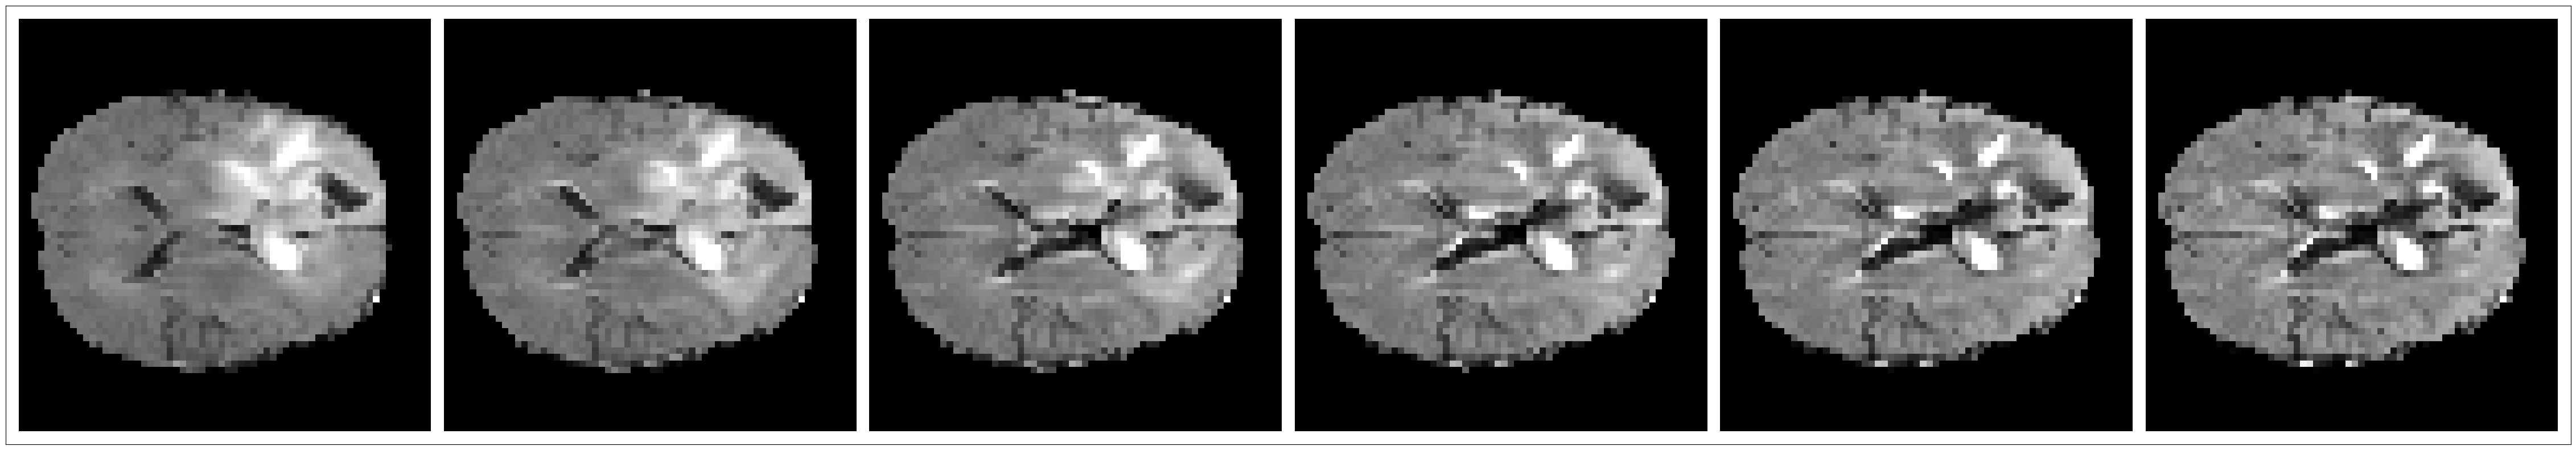

GT Label:  1 6
Before Dist:  1.453008790129351
[1.453008790129351, 1.3105089021596197, 1.1680090143037707, 1.025509126447922, 0.883009238592073, 0.7405093507362243]


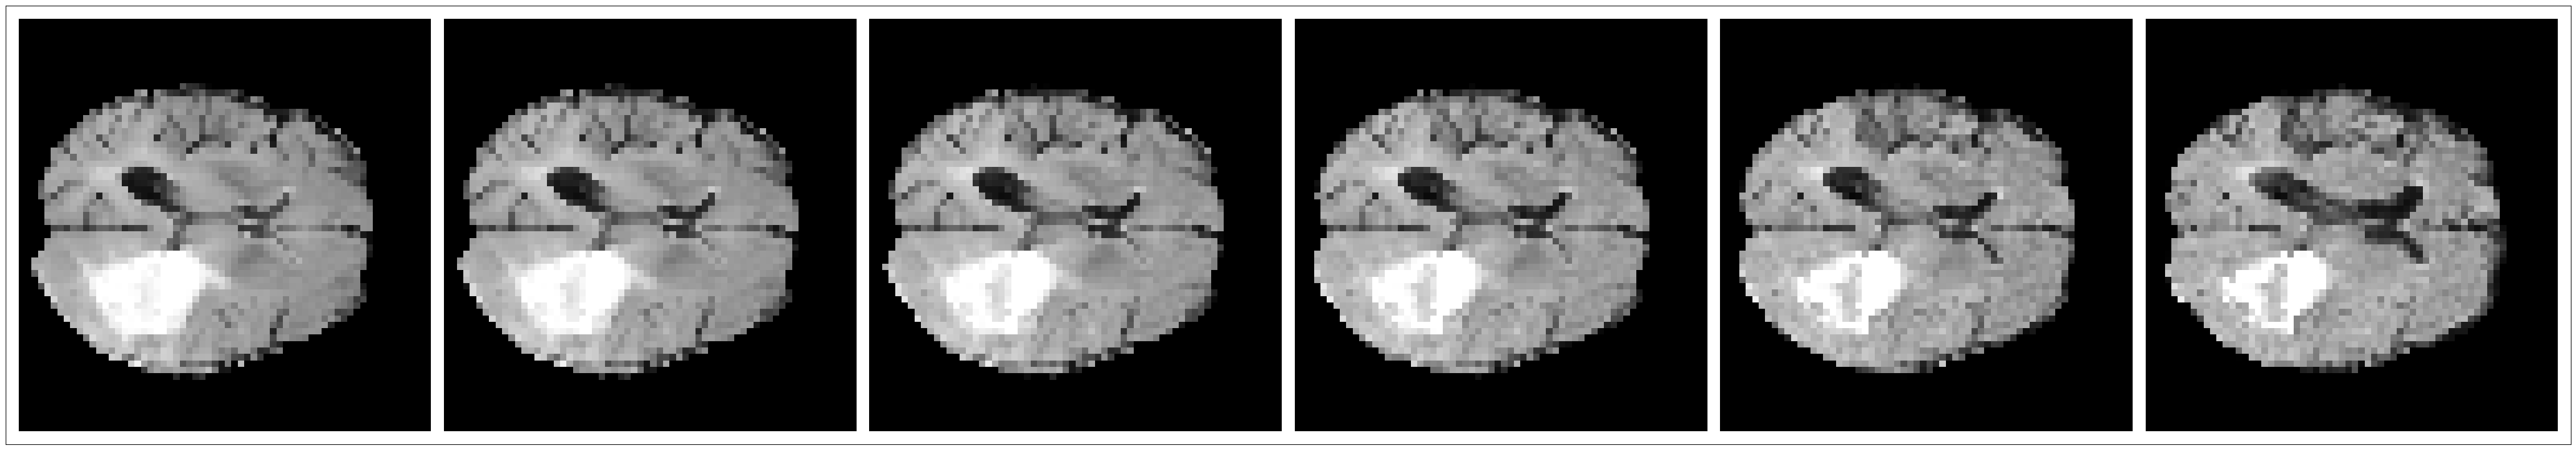

GT Label:  1 10
Before Dist:  1.451323261004991
[1.451323261004991, 1.3088233719209614, 1.1663234840651127, 1.0238235962092637, 0.8813237083534149, 0.7388238204975659]


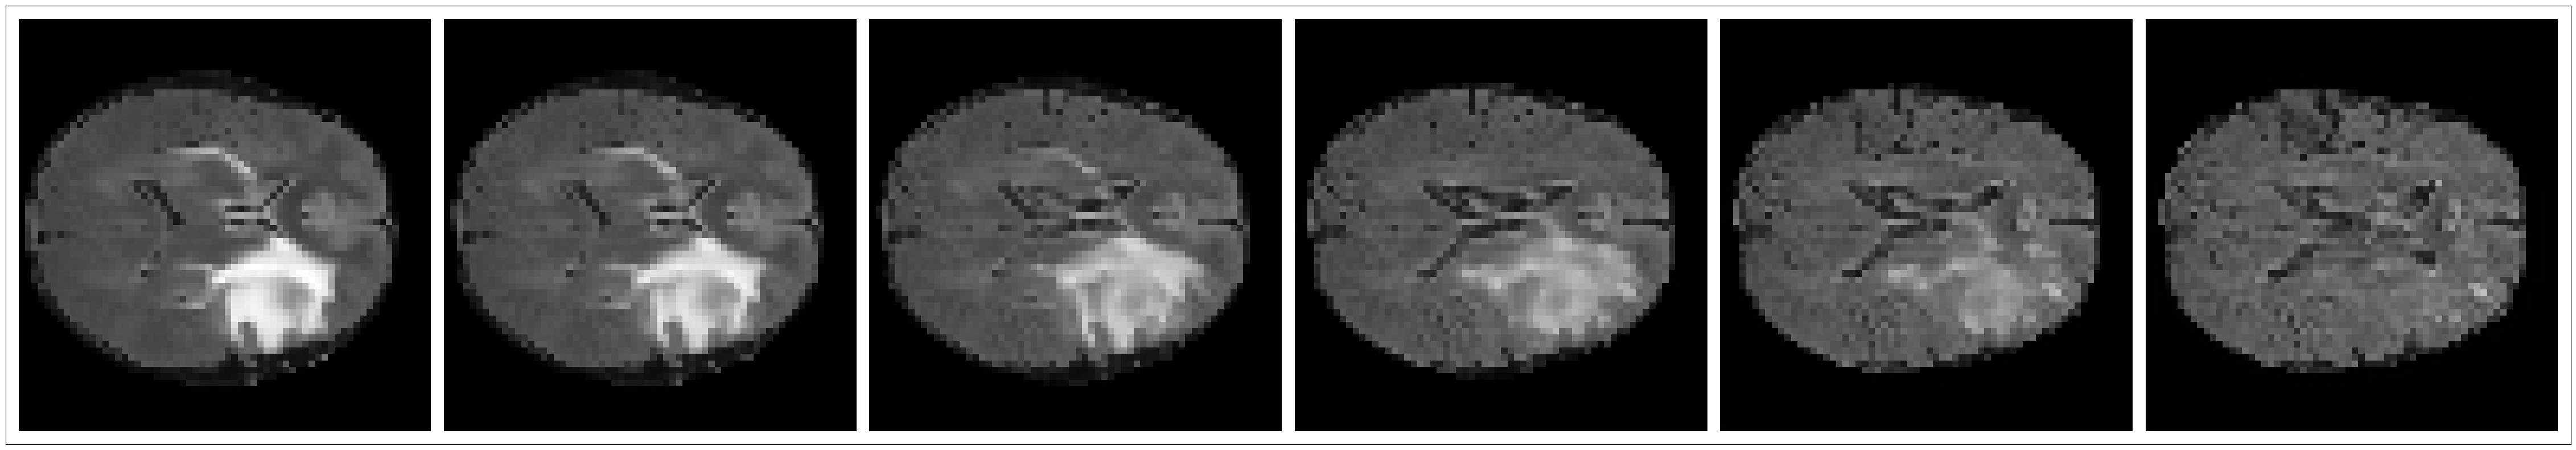

GT Label:  1 11
Before Dist:  1.4043676579853521
[1.4043676579853521, 1.2618677700269445, 1.1193678821710957, 0.9768679943152467, 0.8343681064593982, 0.6918682186035492]


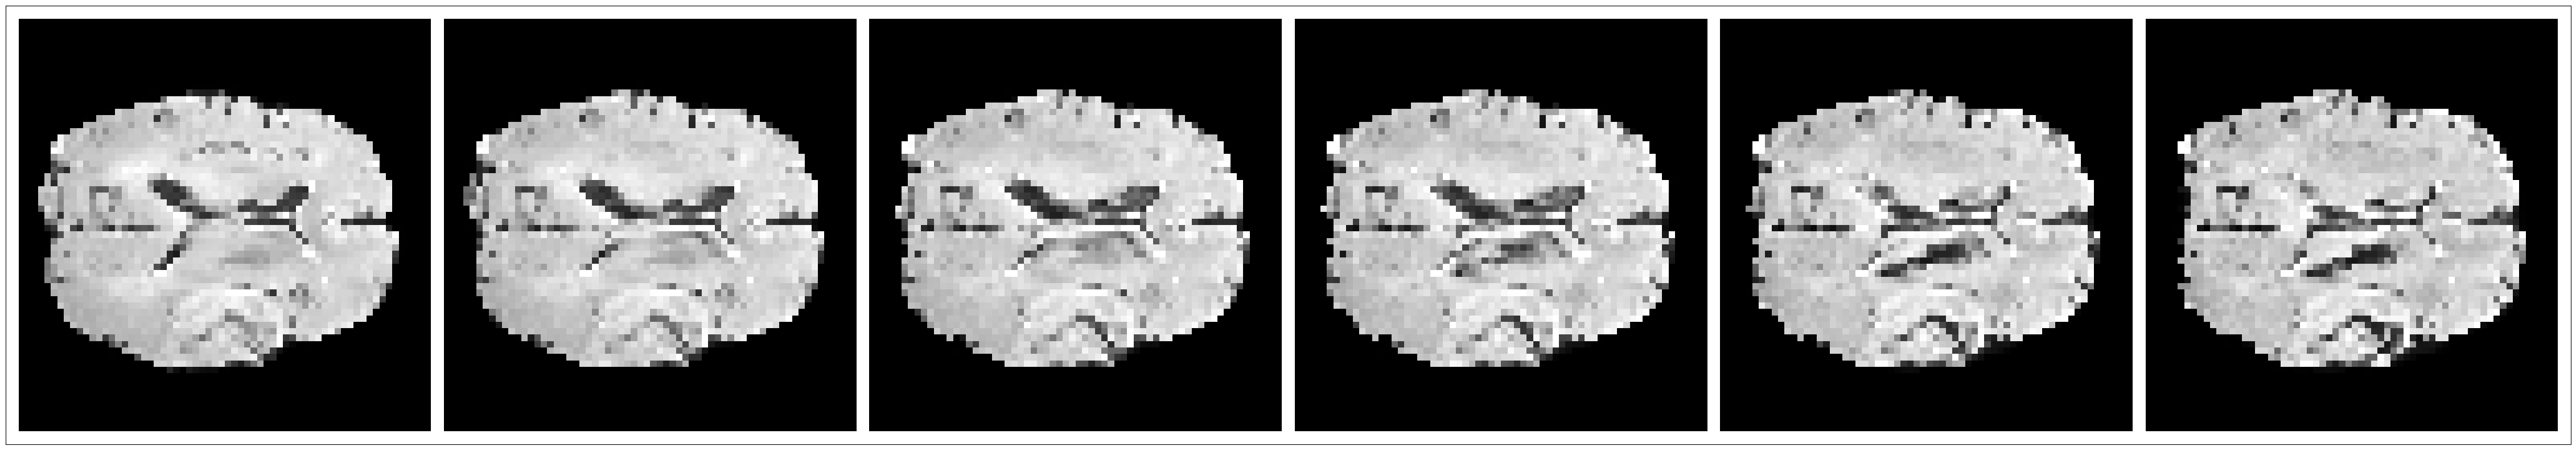

GT Label:  1 12
Before Dist:  1.4007676042154802
[1.4007676042154802, 1.2582677171020584, 1.1157678292462094, 0.9732679413903607, 0.8307680535345117, 0.6882681656786629]


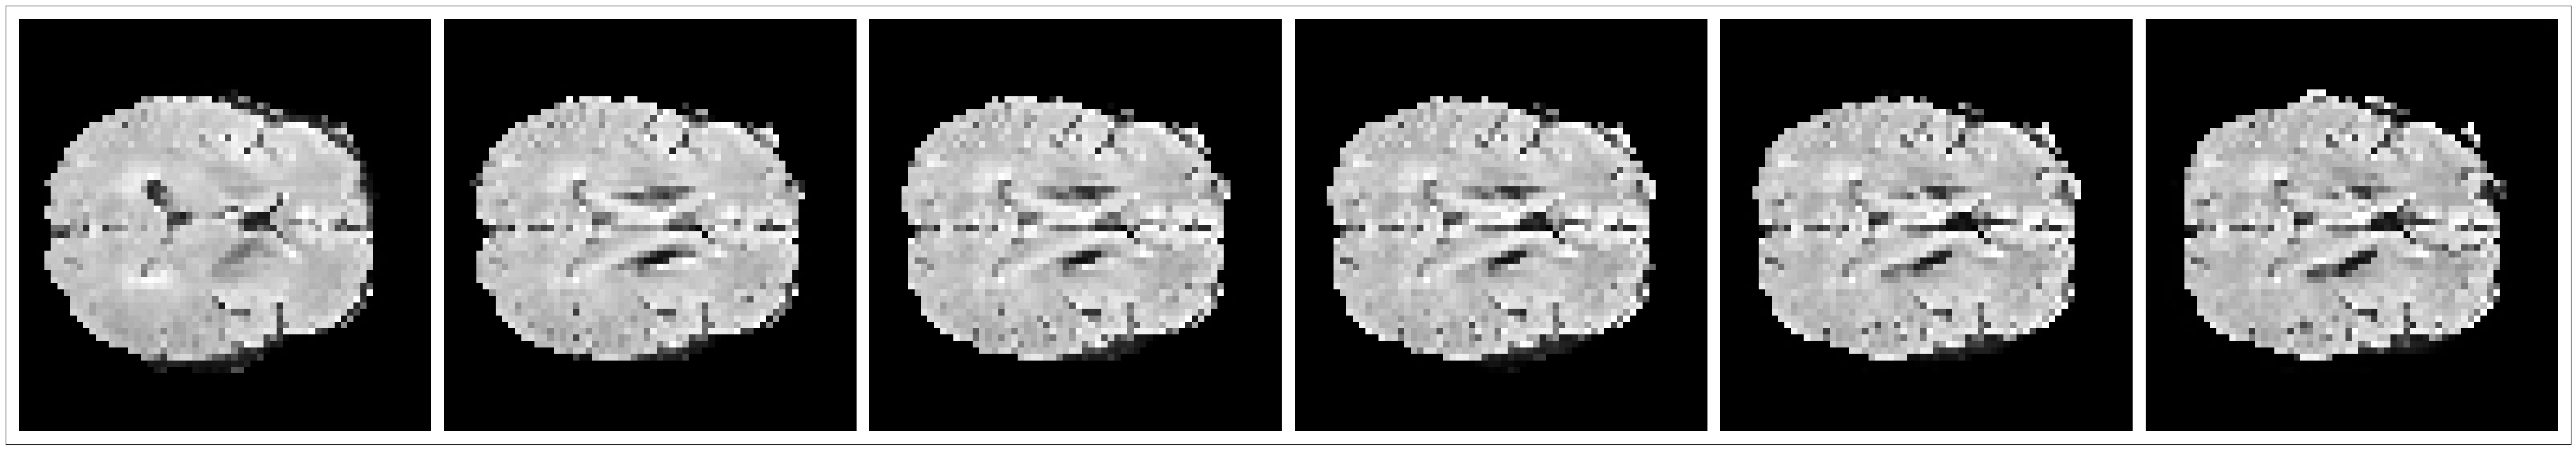

GT Label:  1 13
Before Dist:  1.4305055219486342
[1.4305055219486342, 1.288005634397134, 1.1455057465412852, 1.0030058586854365, 0.8605059708295875, 0.7180060829737386]


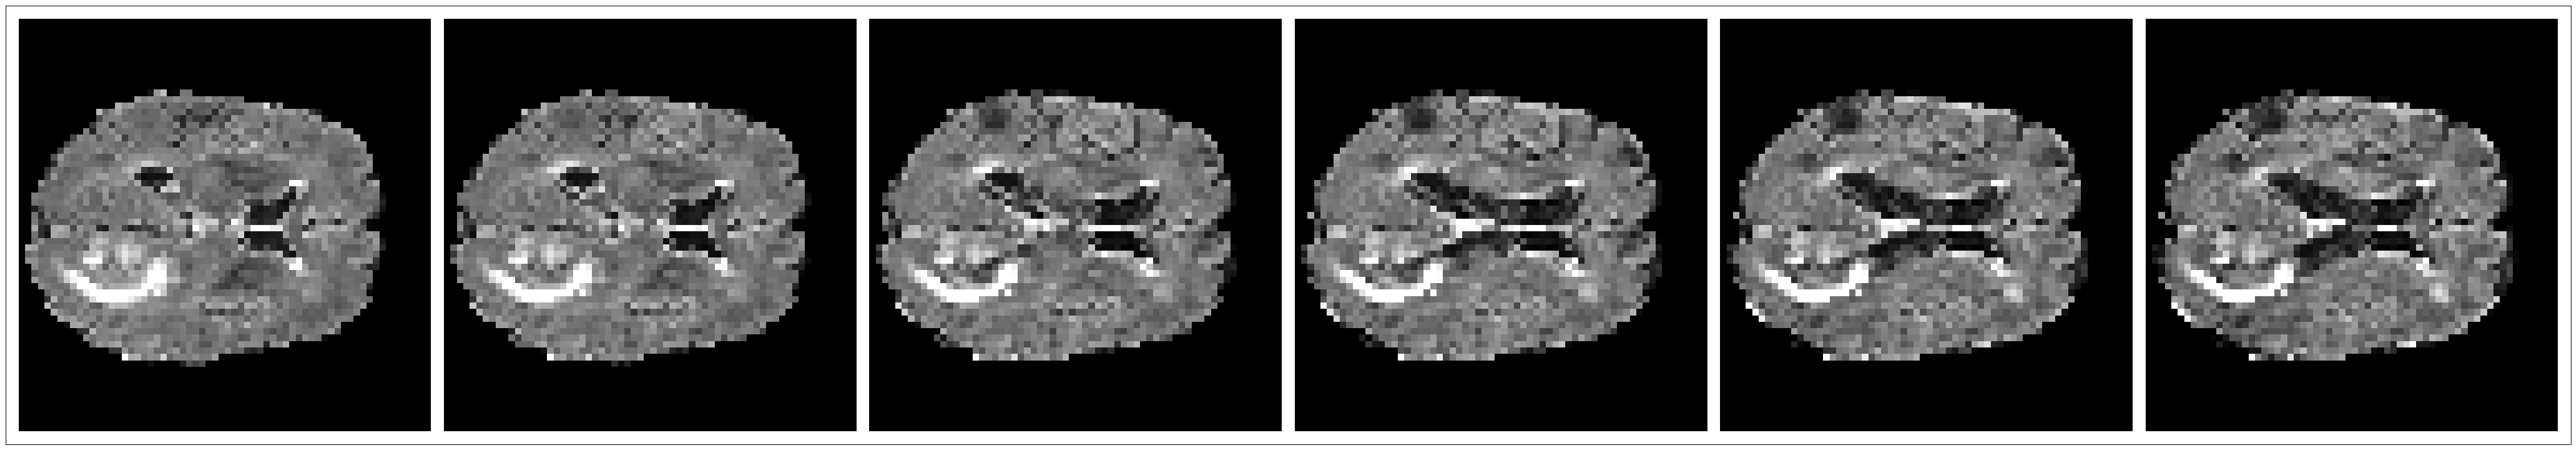

GT Label:  1 15
Before Dist:  1.4316513488433145
[1.4316513488433145, 1.2891514606809407, 1.1466515728250917, 1.004151684969243, 0.8616517971133941, 0.7191519092575452]


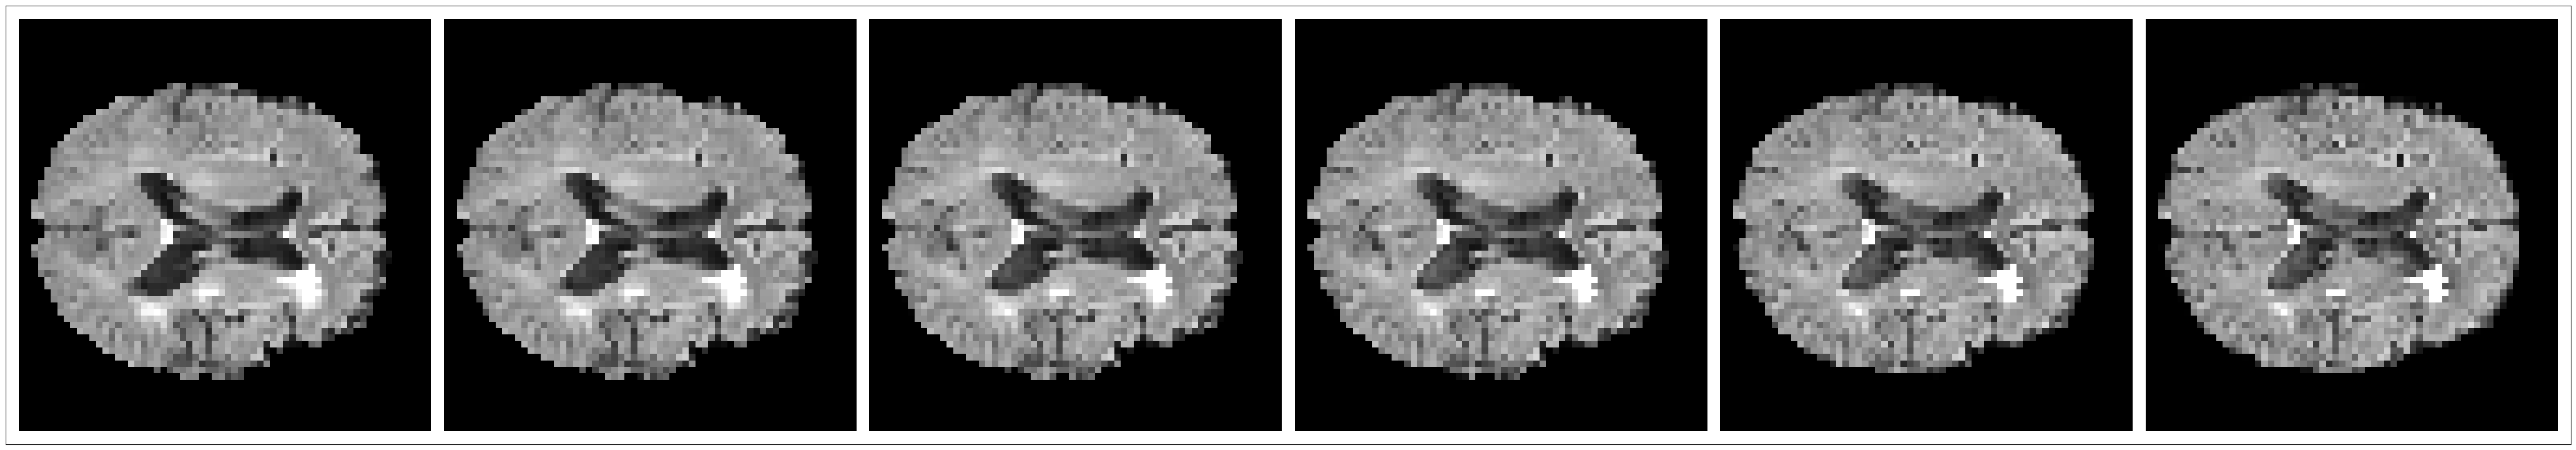

GT Label:  1 16
Before Dist:  1.4611525077025558
[1.4611525077025558, 1.3186526204325217, 1.1761527325766727, 1.033652844720824, 0.8911529568649752, 0.7486530690091262]


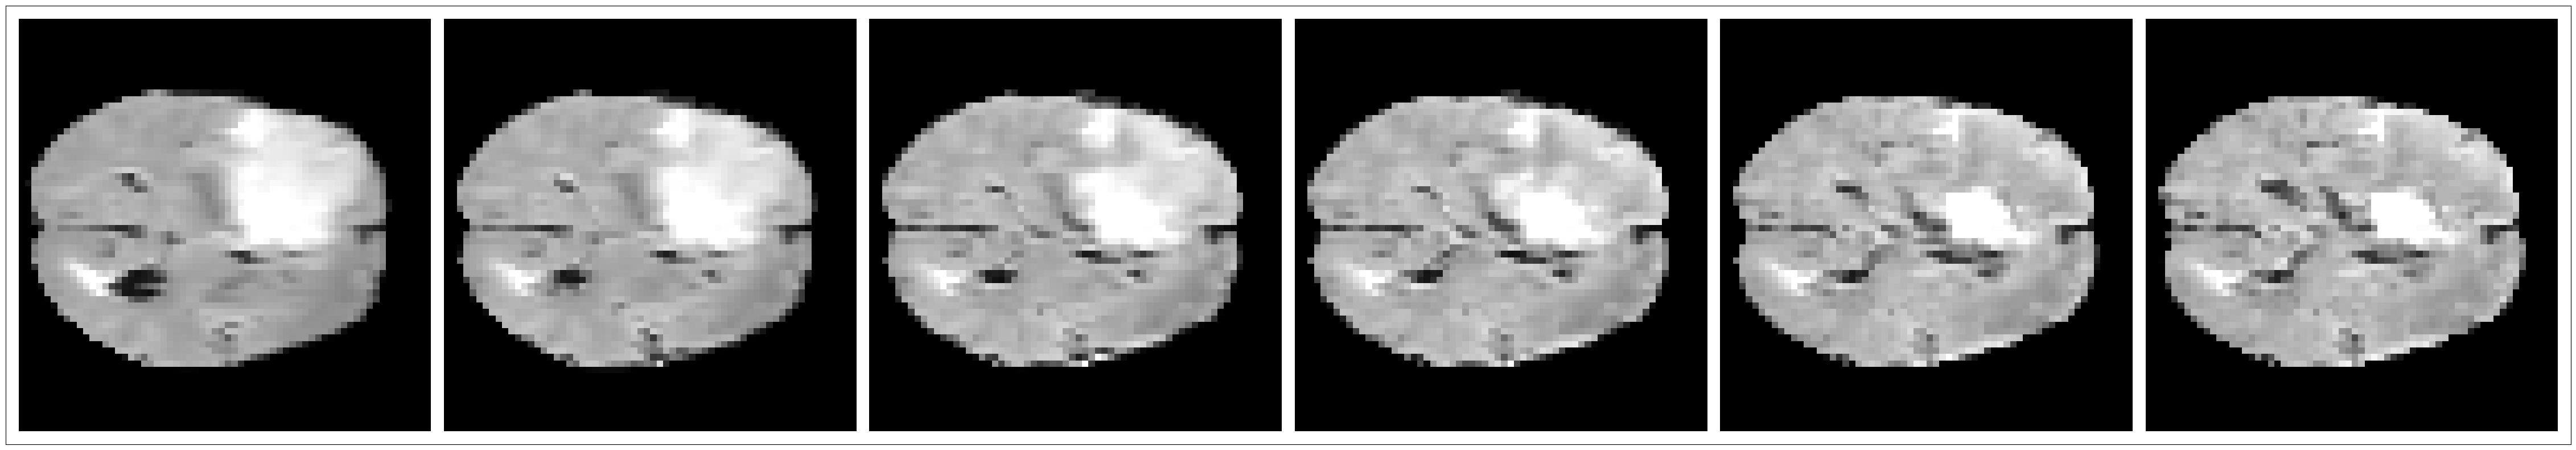

GT Label:  1 17
Before Dist:  1.4599424326598238
[1.4599424326598238, 1.317442544861822, 1.1749426570059733, 1.0324427691501243, 0.8899428812942756, 0.7474429934384266]


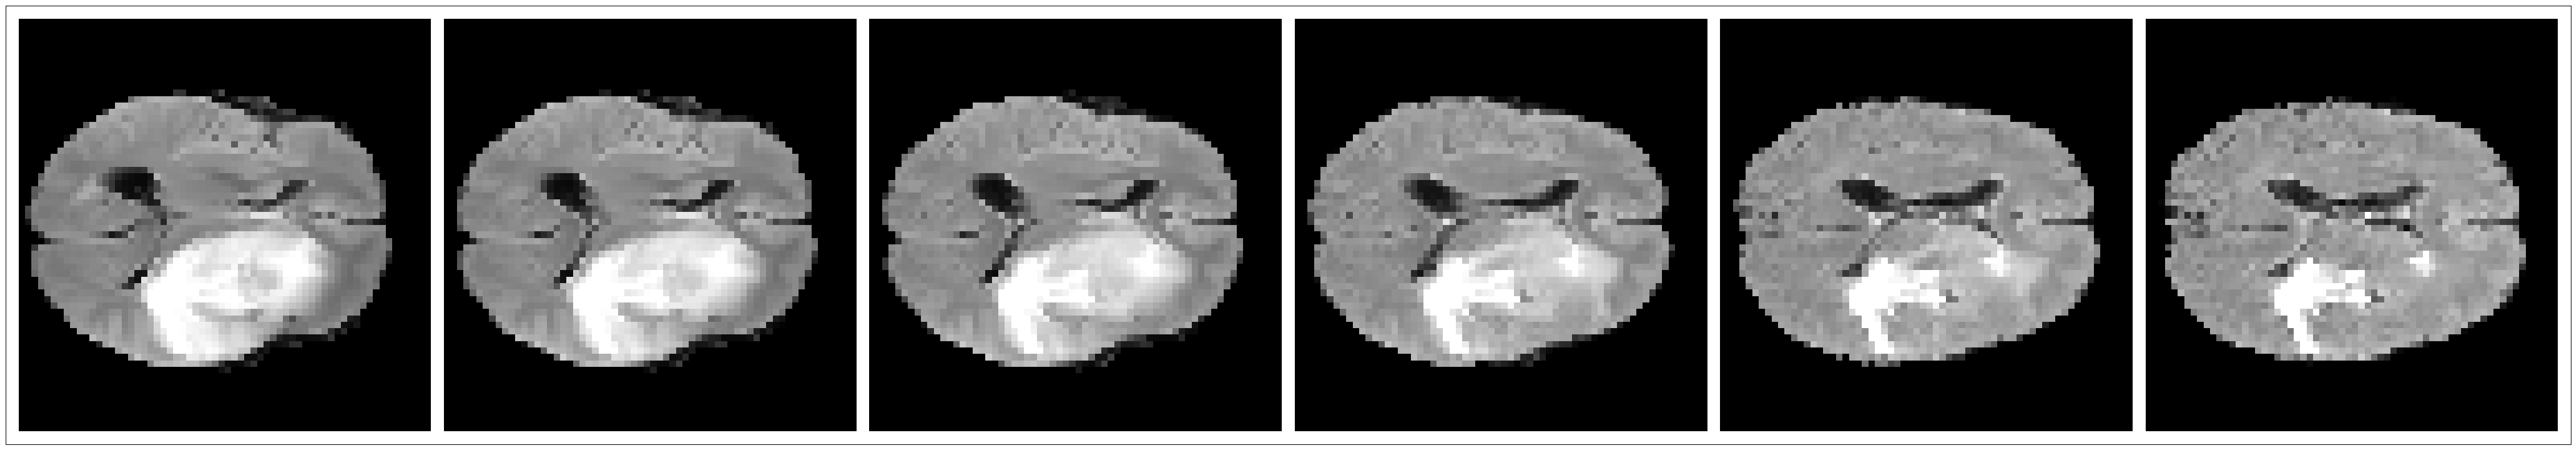

GT Label:  1 18
Before Dist:  1.4138067015124487
[1.4138067015124487, 1.2713068141276267, 1.128806926271778, 0.9863070384159289, 0.8438071505600802, 0.7013072627042312]


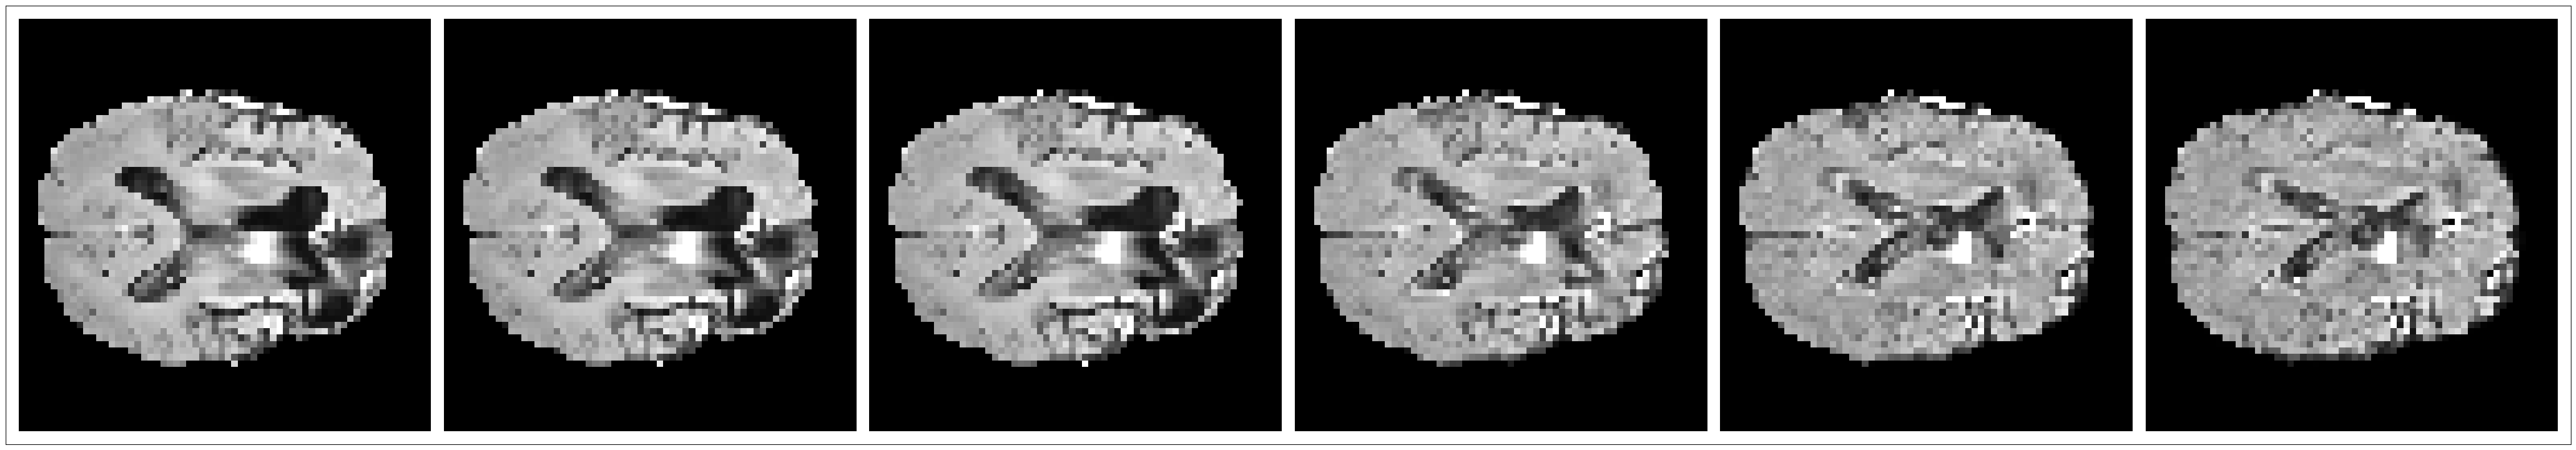

GT Label:  1 19
Before Dist:  1.4280330462388011
[1.4280330462388011, 1.2855331587034842, 1.1430332708476354, 1.0005333829917864, 0.8580334951359375, 0.7155336072800889]


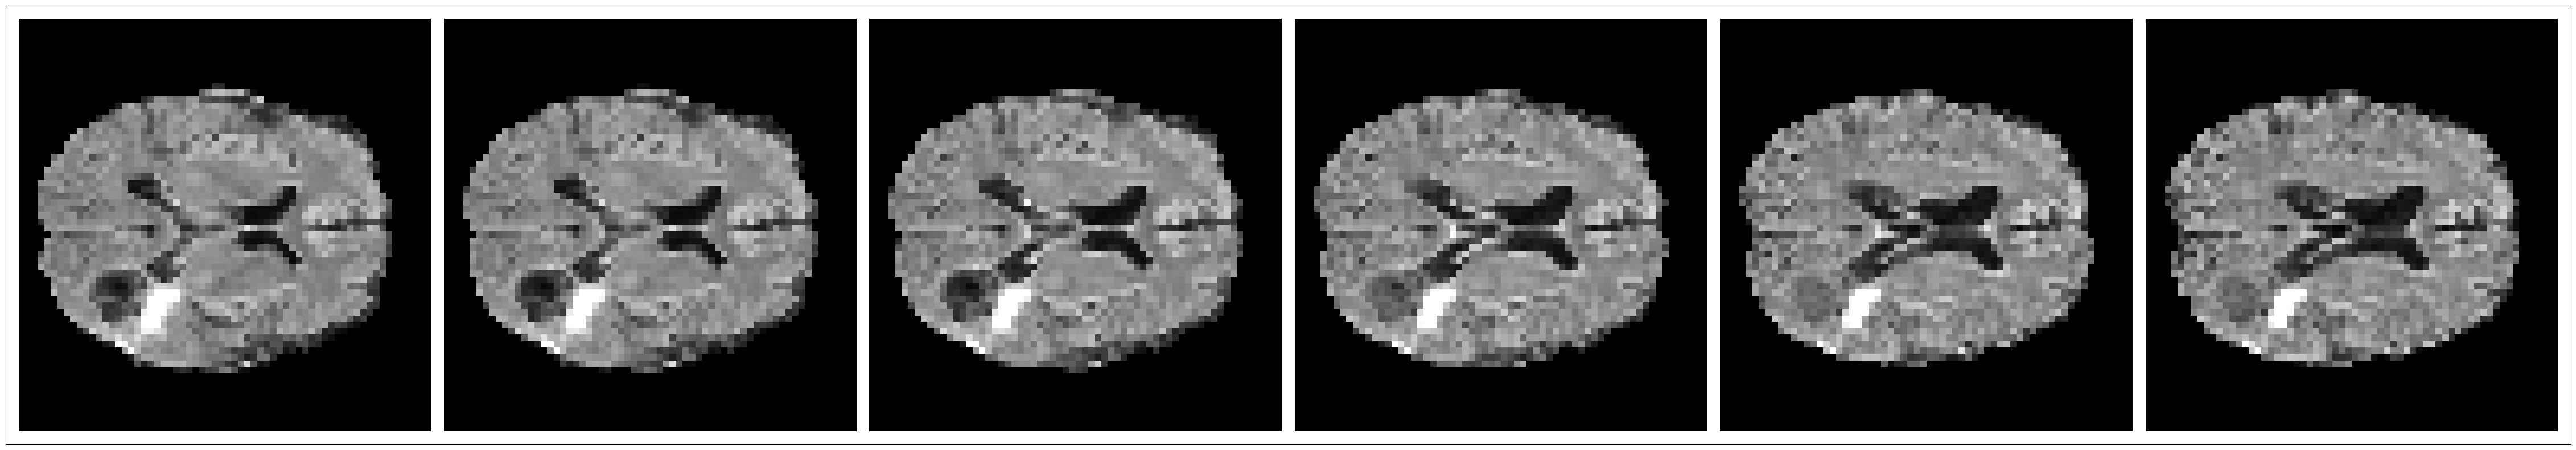

GT Label:  1 20
Before Dist:  1.4522426592606723
[1.4522426592606723, 1.309742771046593, 1.1672428831907442, 1.0247429953348954, 0.8822431074790464, 0.7397432196231977]


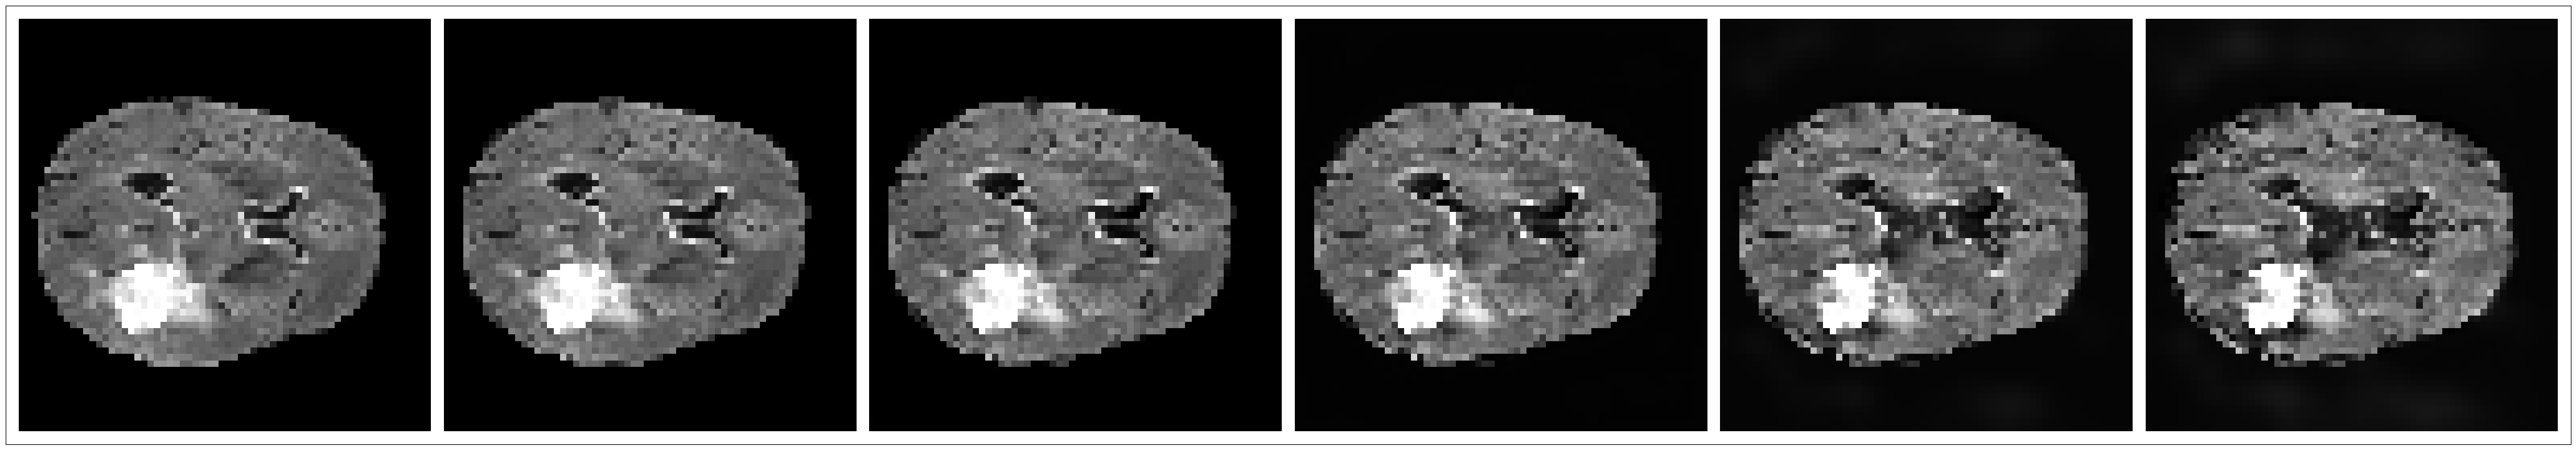

GT Label:  1 21
Before Dist:  1.5237041860289908
[1.5237041860289908, 1.3812042980516324, 1.2387044101957834, 1.0962045223399346, 0.9537046344840858, 0.811204746628237]


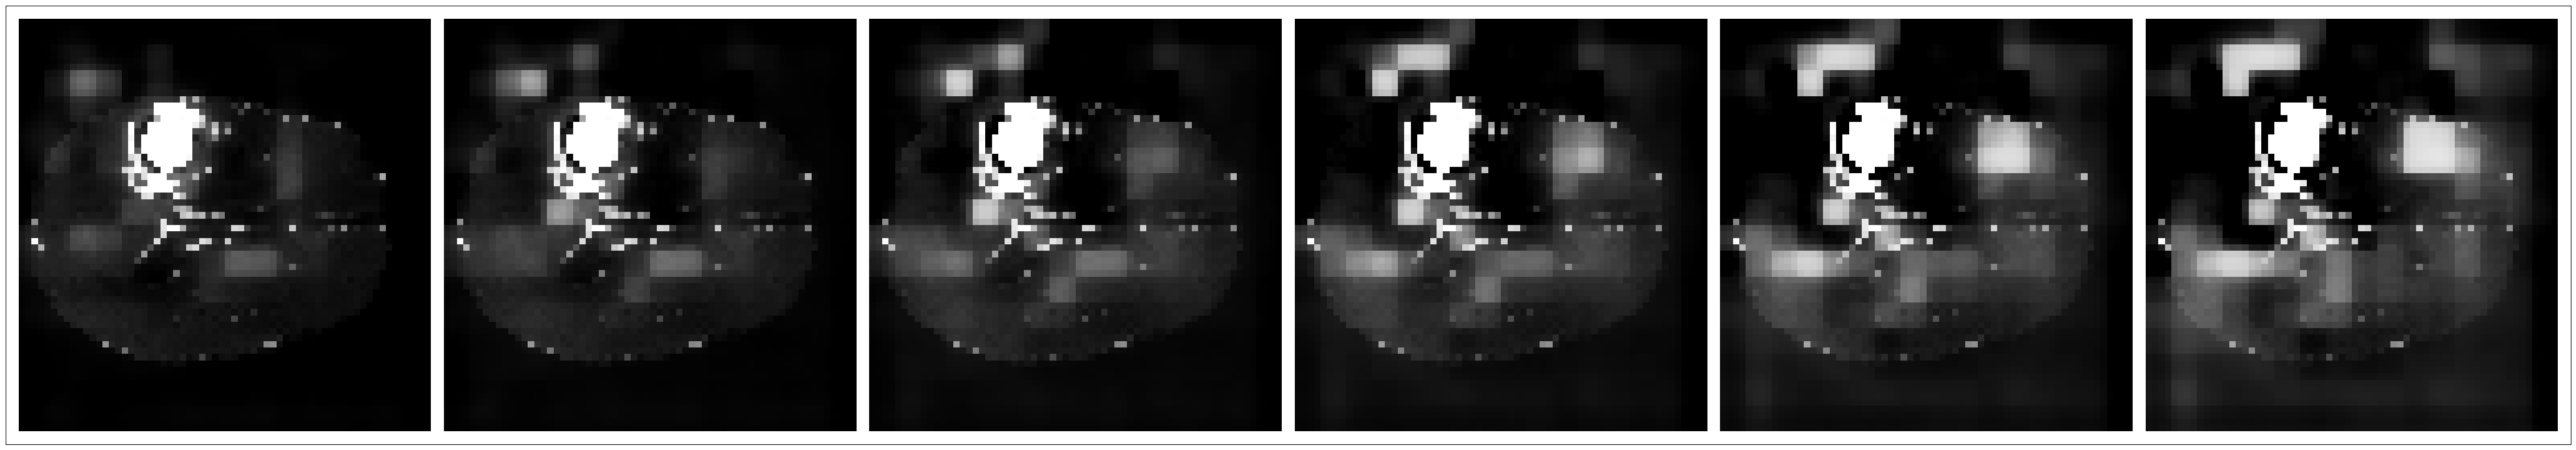

GT Label:  1 22
Before Dist:  1.4409528285707556
[1.4409528285707556, 1.2984529400830134, 1.1559530522271646, 1.0134531643713156, 0.8709532765154668, 0.7284533886596178]


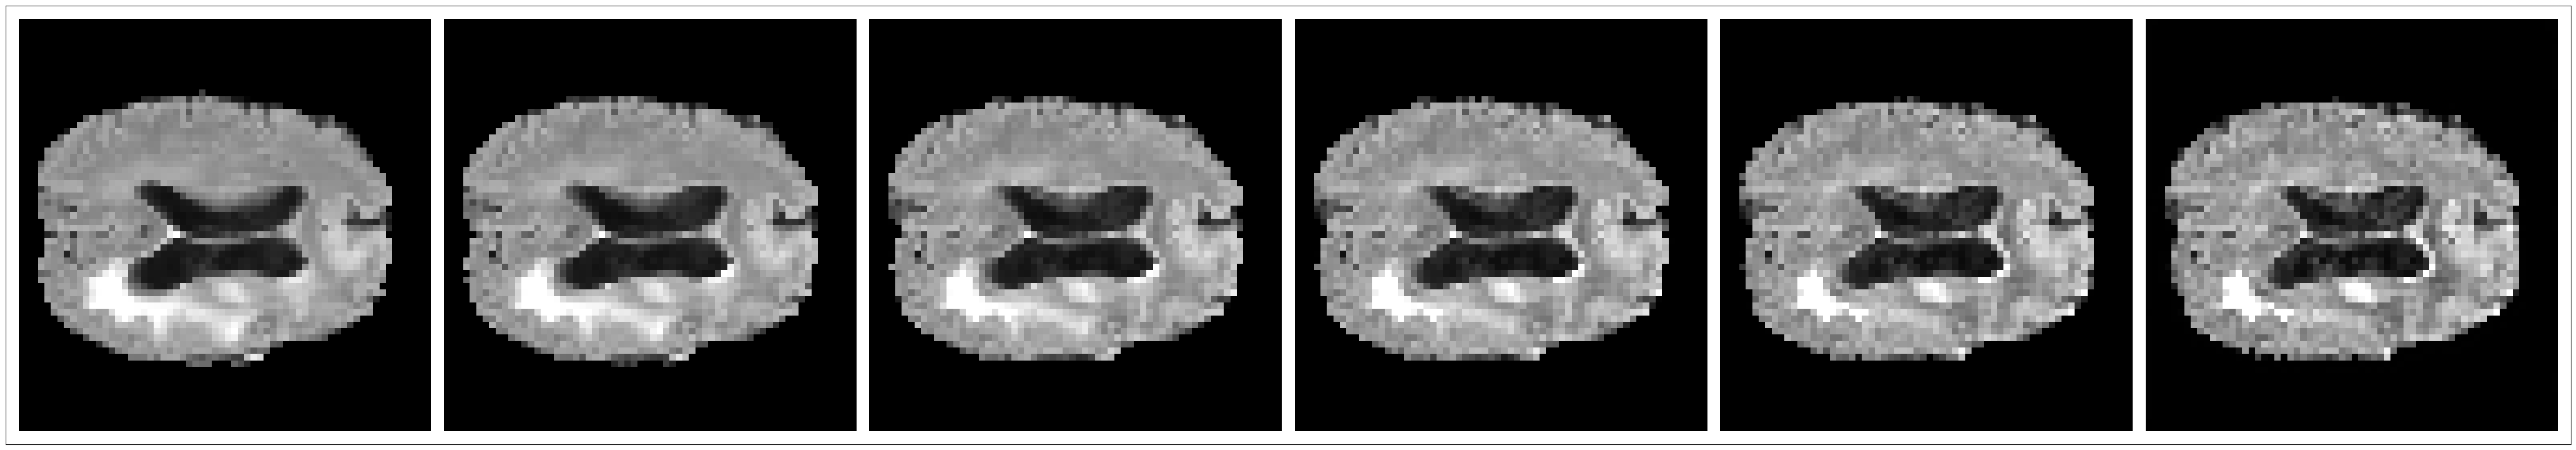

GT Label:  1 24
Before Dist:  1.409282832556053
[1.409282832556053, 1.2667829461760487, 1.1242830583202, 0.9817831704643509, 0.8392832826085019, 0.6967833947526533]


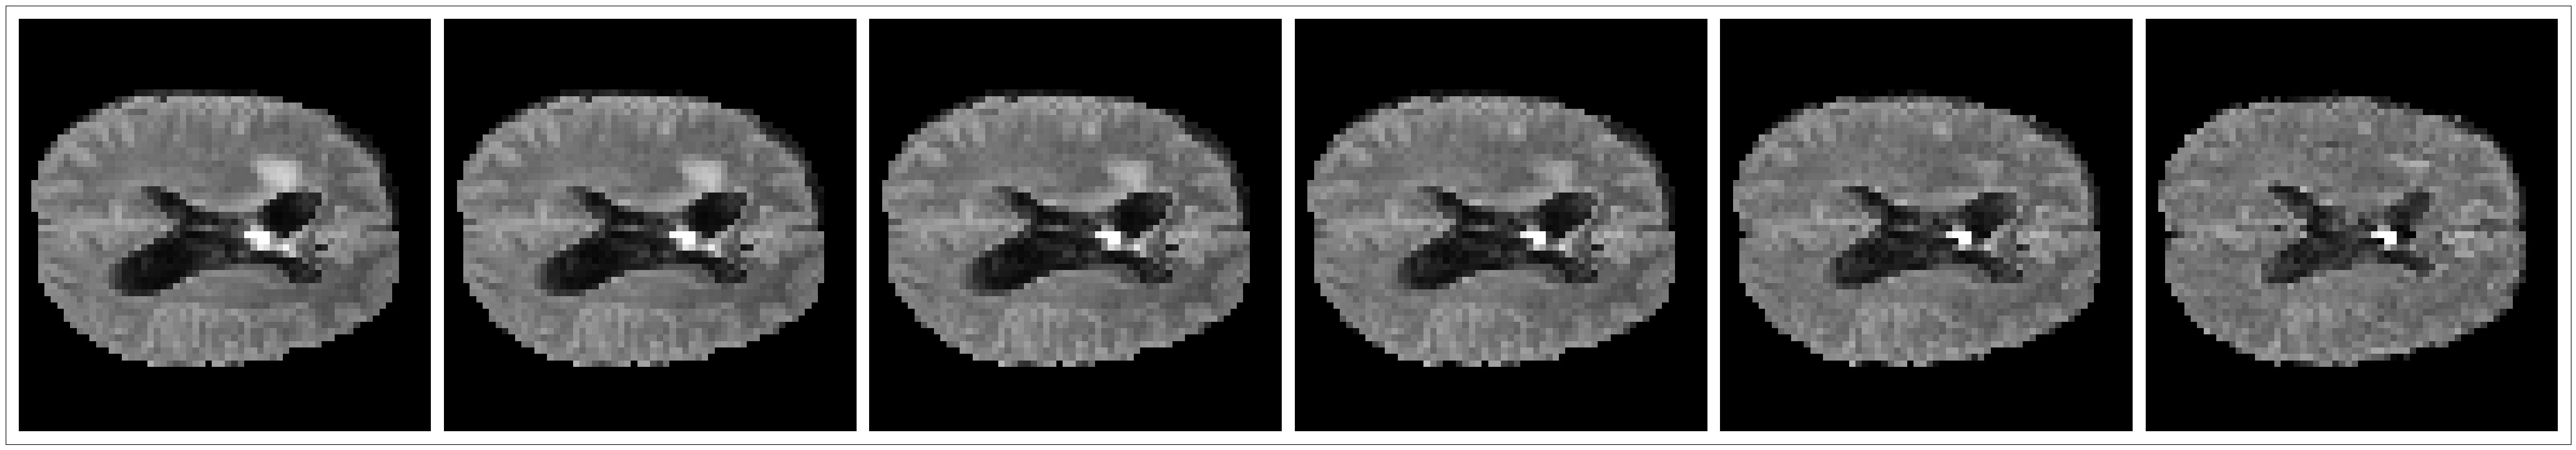

GT Label:  1 26
Before Dist:  1.4611155548829917
[1.4611155548829917, 1.3186156673212324, 1.1761157794653834, 1.0336158916095346, 0.8911160037536858, 0.7486161158978368]


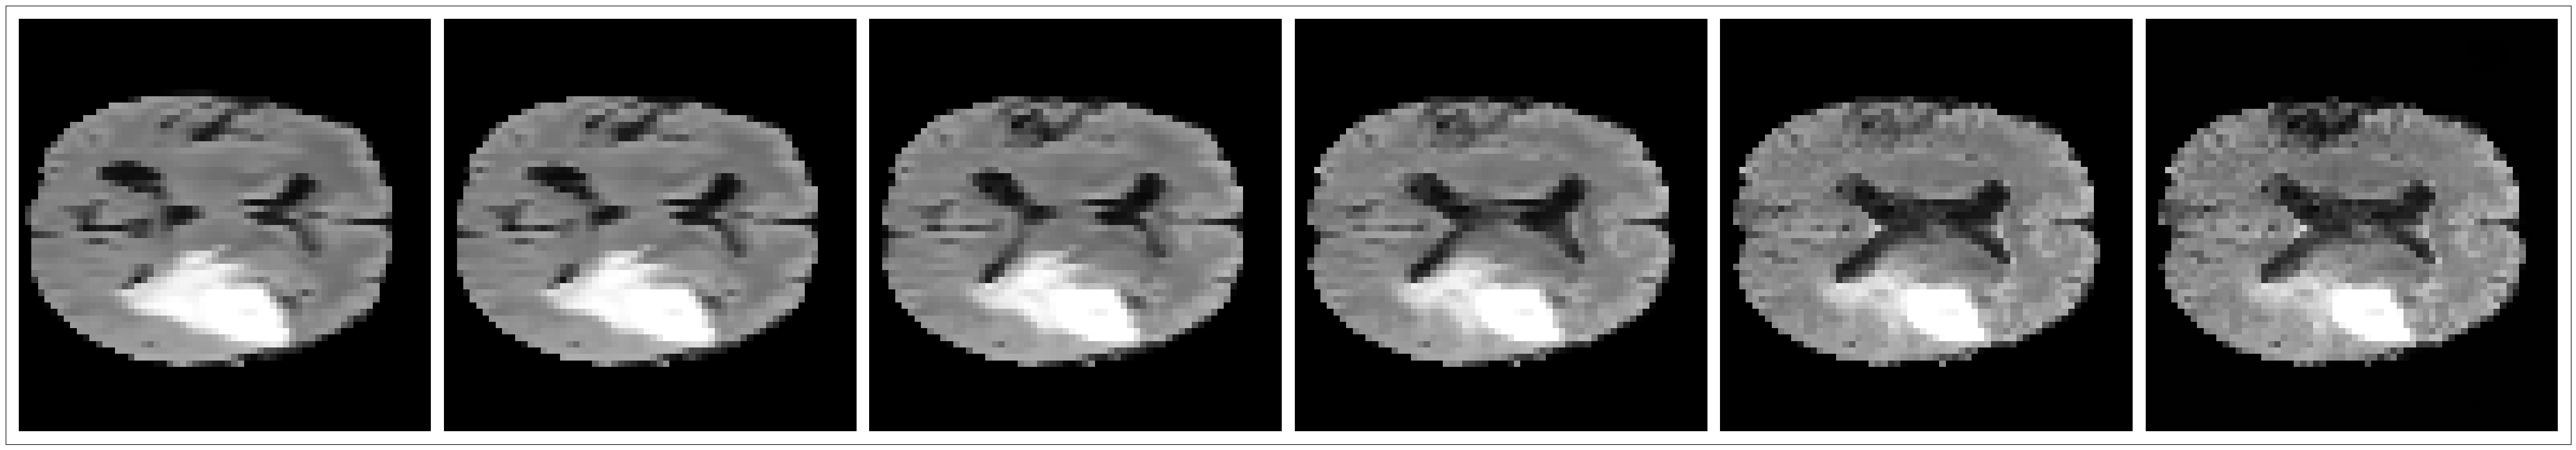

GT Label:  1 27
Before Dist:  1.445280522471594
[1.445280522471594, 1.3027806348346123, 1.1602807469787633, 1.0177808591229145, 0.8752809712670656, 0.7327810834112167]


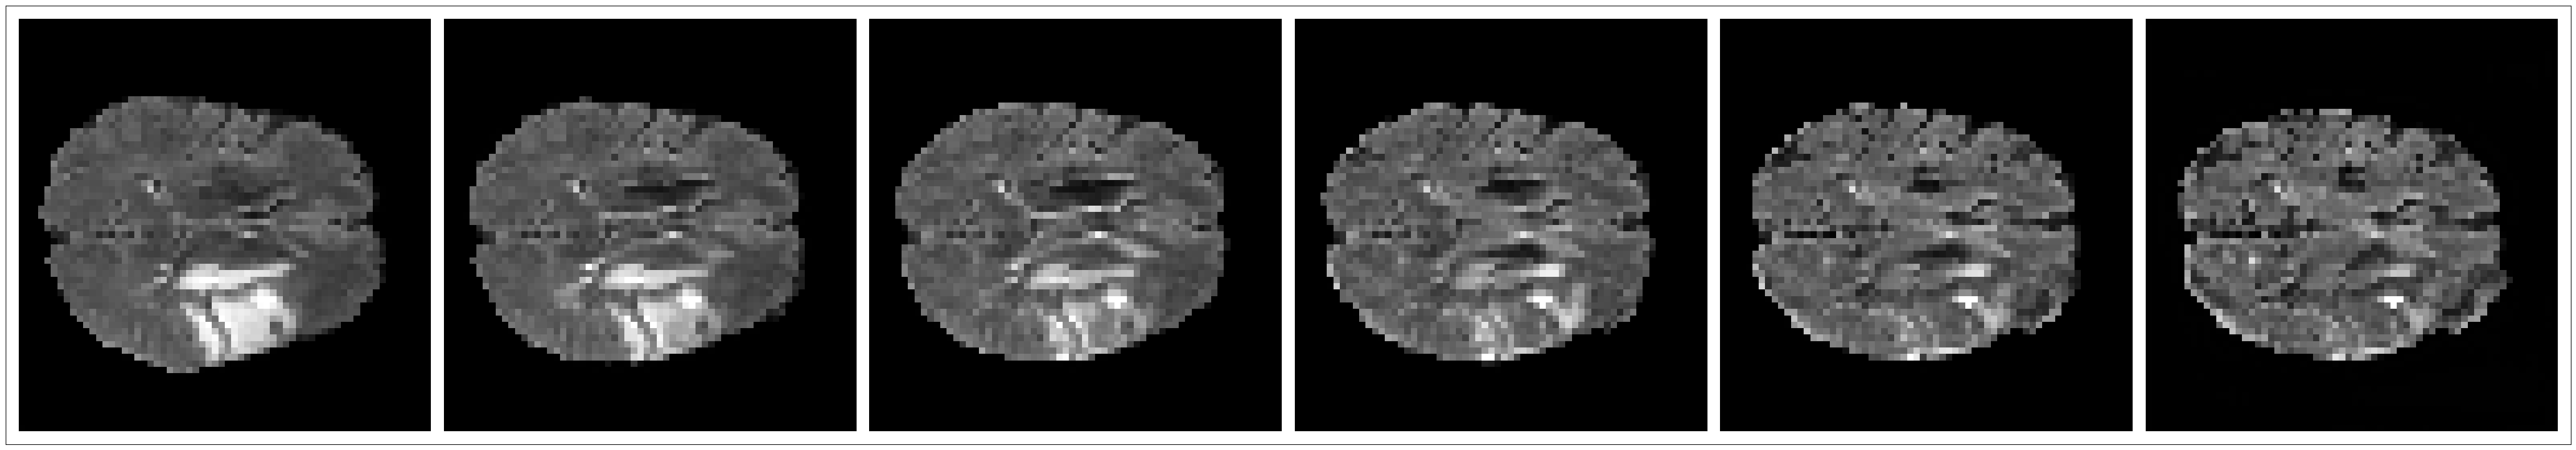

GT Label:  1 28
Before Dist:  1.4529197535651925
[1.4529197535651925, 1.31041986488623, 1.167919977030381, 1.0254200891745322, 0.8829202013186832, 0.7404203134628345]


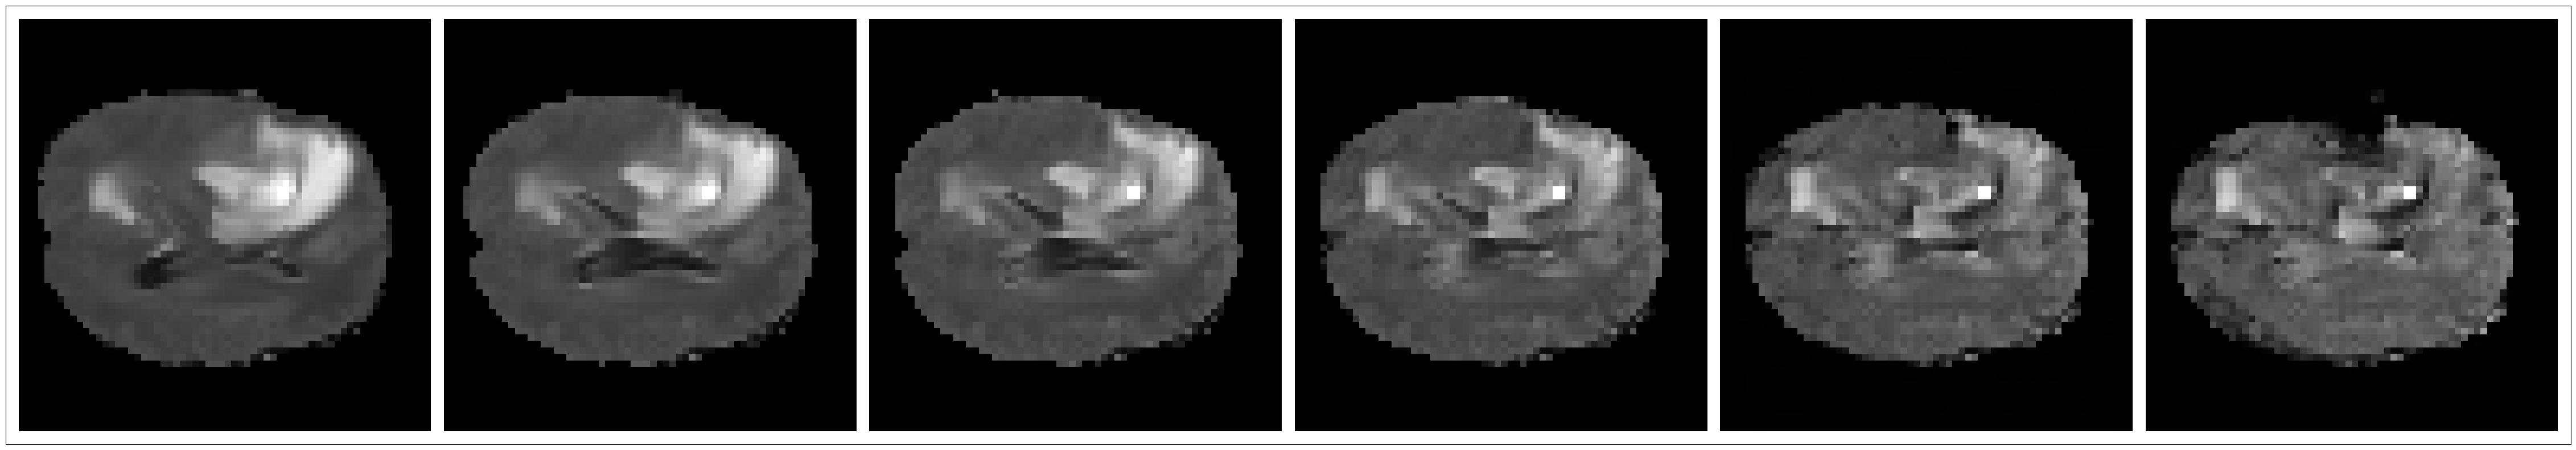

GT Label:  1 29
Before Dist:  1.4405614990213256
[1.4405614990213256, 1.2980616122481101, 1.1555617243922613, 1.0130618365364124, 0.8705619486805636, 0.7280620608247147]


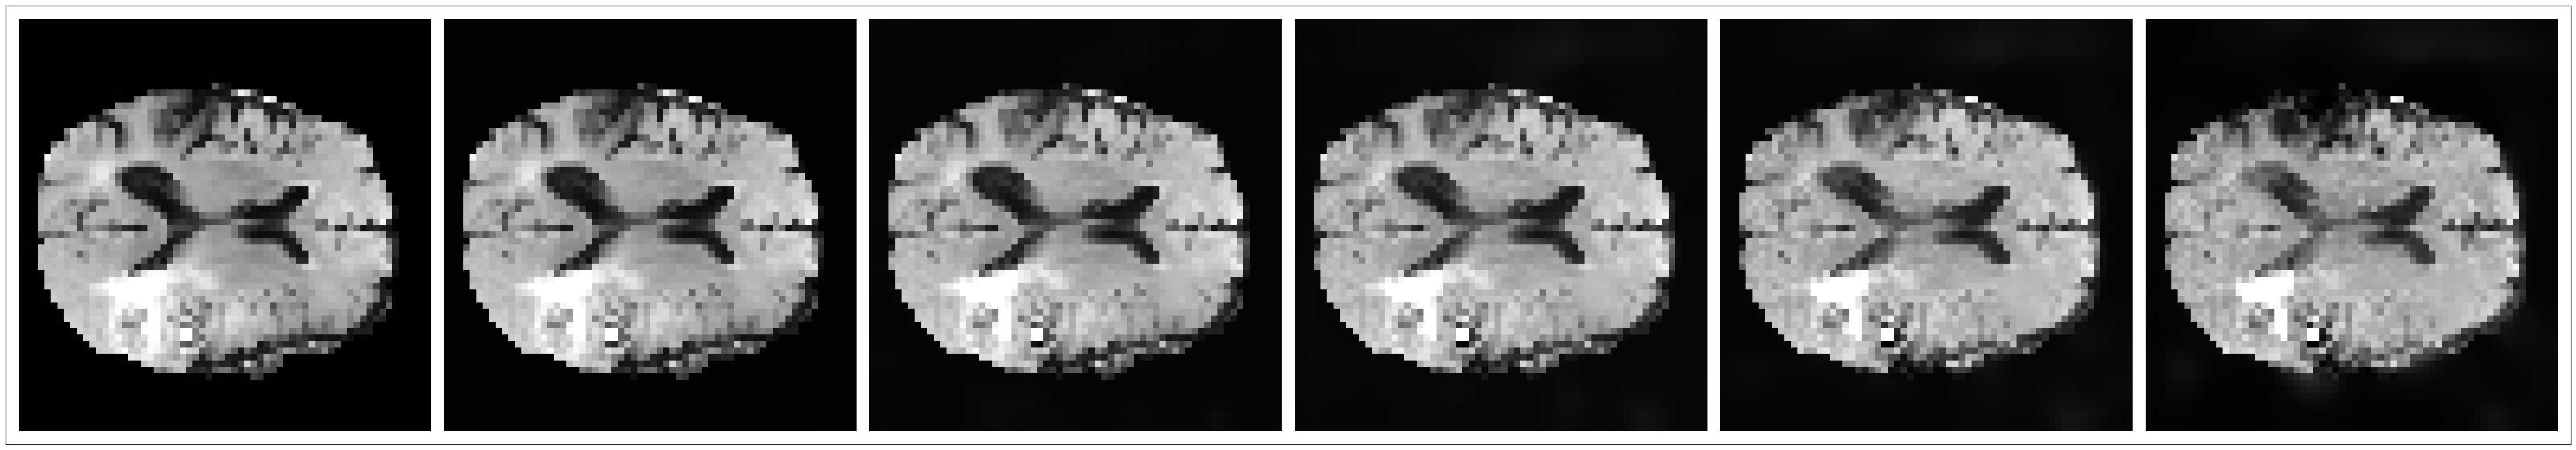

GT Label:  1 30
Before Dist:  1.4404728549101848
[1.4404728549101848, 1.2979729659530272, 1.1554730780971785, 1.0129731902413295, 0.8704733023854807, 0.7279734145296318]


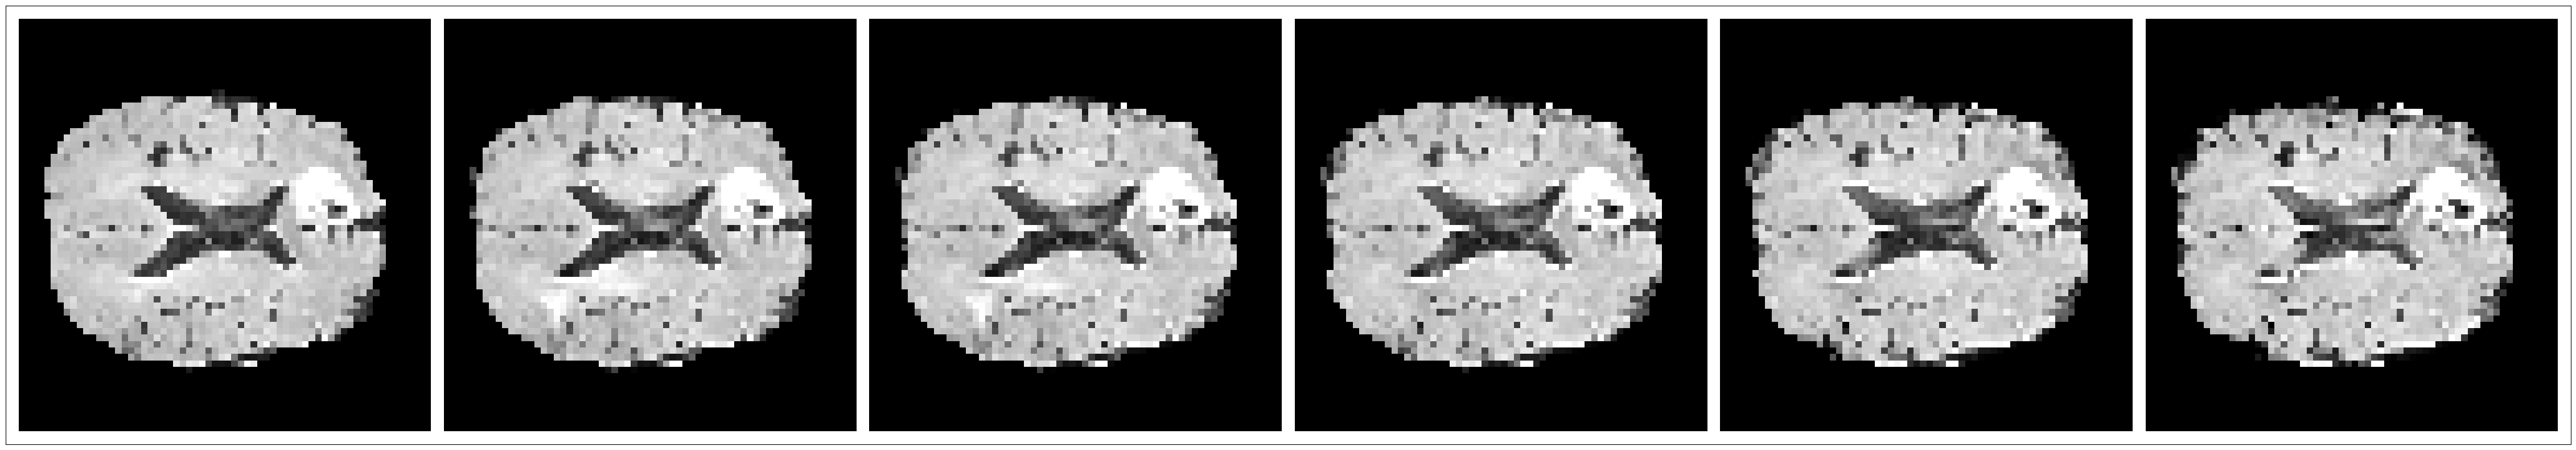

In [40]:
for i, batch in enumerate(val_loader):
    if i != 10:
        continue
    
    gt_label = int((batch["label"].numpy() == 2).any())
    if gt_label == 0:
        continue
    print("GT Label: ", gt_label, i)

    orig_img = batch["image"].to(device)
    
    cond =  model.encode(orig_img, ema=True)
    xT = model.encode_stochastic(orig_img, cond, T=250, ema=True)
    recon_img = model.render(xT, cond, T=100, ema=True)

    with torch.no_grad():
        edit_conds = move_across_boundary(cond, svm_model, gt_label)
    
    edit_imgs = model.render(torch.cat([xT for i in range(len(edit_conds))]), torch.cat(edit_conds, dim=0), T=100, ema=True)
    grid = torchvision.utils.make_grid(torch.cat([recon_img, edit_imgs], dim=0), pad_value=255)
    show(grid)
    plt.show(block=False)

    break
